In [1]:
import pandas as pd
import numpy as np
from sklearn import cluster
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy import stats

D:\python\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
df = pd.read_excel('D:/UW/project/New projects 20200714/20201109_TWP_dilution/TWP_stock_dilution_50xconc.xlsx')

In [98]:
#read in data
df = pd.read_excel('20201104_neg_pref.xlsx')
#df.drop(columns=['Unnamed: 0', 'am.rt'], inplace=True)

In [15]:
#Blank subtraction
blank_col=[i for i in df.columns if 'Blank' in i]
d_bs = df[df.iloc[:,3:][[i for i in df.iloc[:,3:].columns if i not in blank_col]].max(1) > df[blank_col].mean(1) * 5].copy()
d_bs.drop(columns=blank_col, inplace=True)
d_bs = d_bs[d_bs['S/N average'] >= 20]
d_bs = d_bs[(d_bs['Average Rt(min)'] <= 20) &(d_bs['Average Rt(min)'] >= 2)]
d_bs = d_bs[d_bs['Average Mz'] <= 800]

In [17]:
d_bs.shape

(2533, 11)

In [21]:
#Normalization
#target_col = []
sel_data = d_bs.iloc[:,-7:].copy()
c_data = sel_data.values #Change upon data
c_norm = []
#Performs normalization
np.seterr(divide='ignore', invalid='ignore') #silent the warning -- but divide by 0 still exist
for row in c_data:
    c_norm.append((row-np.mean(row))/np.std(row))
#Clean up dataframe
c_norm = np.asarray(c_norm)
d_norm = pd.DataFrame(c_norm)
d_norm['index']=d_bs.index
d_norm.set_index('index',inplace=True)
d_norm.dropna(how='all',inplace=True)
d_norm.columns = sel_data.columns

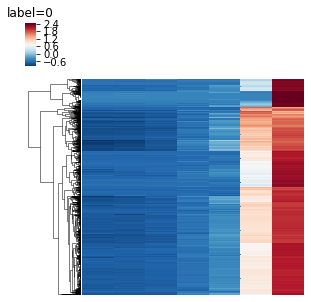

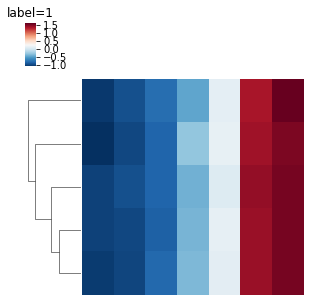

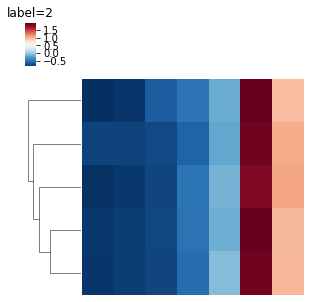

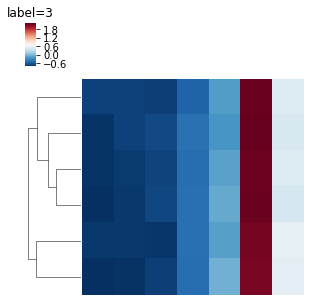

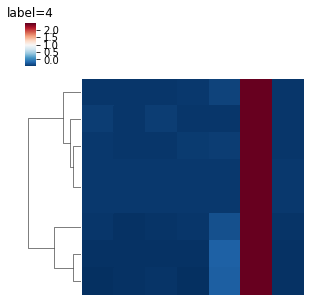

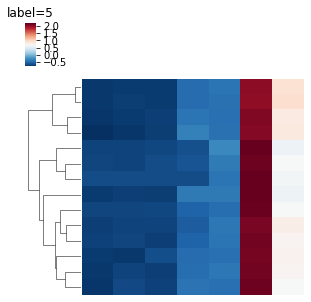

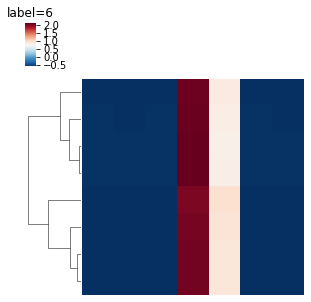

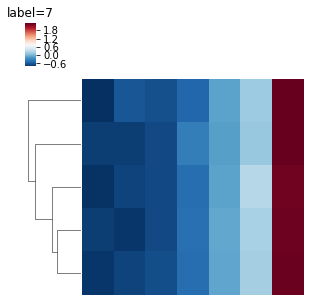

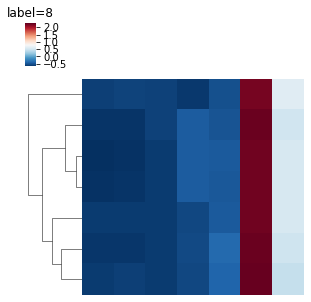

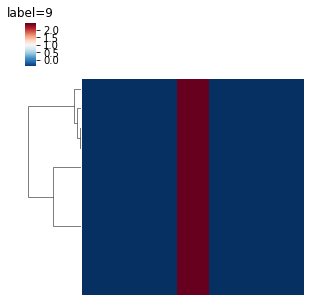

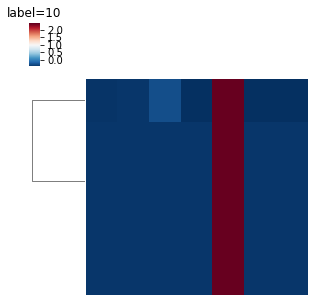

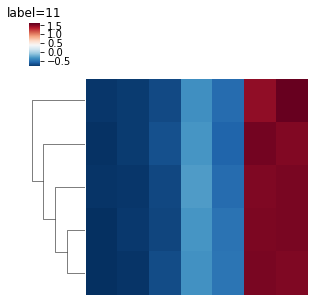

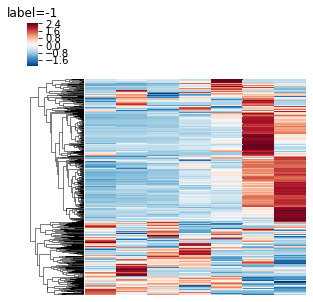

In [78]:
#Automated workflow -- pre filter
#model = cluster.OPTICS().fit(d_norm)
model = cluster.DBSCAN(eps=0.15).fit(d_norm)
labels = model.labels_
unique_labels = set(model.labels_)

for i,k in enumerate(unique_labels):
    indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
    sns.clustermap(d_norm.iloc[indexlist].values,cmap='RdBu_r',col_cluster=False,yticklabels=False,xticklabels=False,figsize=(5,5))
    plt.title('label='+ str(k))
    plt.show()

In [ ]:
#Loss function?

In [76]:
#automated workflow -- post extraction
select_label=[-1]
d_rst = pd.DataFrame(columns=d_norm.columns)
for label in select_label:
    result = d_norm.iloc[np.argwhere(model.labels_==label).flatten()].index
    d_rst = d_rst.append(d_norm.loc[result, d_norm.columns])
d_pri_auto = d_bs.loc[d_rst.index].copy() # d_pri_auto -- automated selected result

In [77]:
d_pri_auto.shape

(2007, 11)

Text(0, 0.5, 'Normalized peak area')

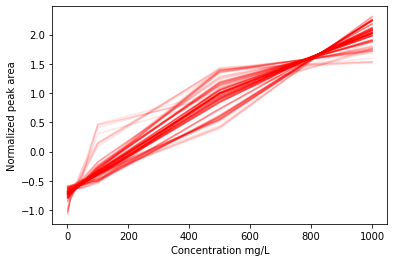

In [39]:
for i,j in d_rst.iterrows():
    plt.plot([1,5,10,50,100,500,1000], j, color='r', alpha=0.1)
plt.xlabel('Concentration mg/L')
plt.ylabel('Normalized peak area')

In [158]:
d_pri_auto.to_excel('automated_priorlist_20201104.xlsx')

In [49]:
#User defined method
#1. find highest point 2. check left and right numbers 3. linear regression & check trend--decrease/increase
r2_thres = 0.9
slope_thres = 0.005
x_series=[1,5,10,50,100,500,1000]

r2_list=[]
slop_list=[]
pattern_index = []
for index,row in d_norm.iterrows():
    max_index = np.argmax(row)
    #Divide from the highest point
    before_max = row[:max_index+1]
    before_x = x_series[:max_index+1]
    after_max = row[max_index:]
    after_x = x_series[max_index:]
    #Check if the number enough for regression
    pattern_count = 0
    if len(before_max) >= 3:
        slope, intercept, r_value, p_value, std_err = stats.linregress(before_x,before_max)
        if r_value**2 >= r2_thres and slope >= slope_thres:
            pattern_count += 1
            r2_list.append(r_value**2)
            slop_list.append(abs(slope))
    if len(after_max) >= 3:
        slope, intercept, r_value, p_value, std_err = stats.linregress(after_x,after_max)
        if r_value**2 >= r2_thres and slope >= slope_thres:
            pattern_count += 1
            r2_list.append(r_value**2)
            slop_list.append(abs(slope))
    if pattern_count > 0:
        pattern_index.append(index)

d_manual = d_norm.loc[pattern_index].copy()

In [69]:
r2_thres = 0.99
slope_thres = 0.002
x_series=[1,5,10,50,100,500,1000]

r2_list=[]
slop_list=[]
pattern_index = []
for index,row in d_norm.iterrows():
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_series,row)
    if r_value**2 >= r2_thres and slope >= slope_thres:
        r2_list.append(r_value**2)
        slop_list.append(abs(slope))
        pattern_index.append(index)

d_manual = d_norm.loc[pattern_index].copy()

In [70]:
d_manual.shape

(642, 7)

Text(0, 0.5, 'Normalized peak area')

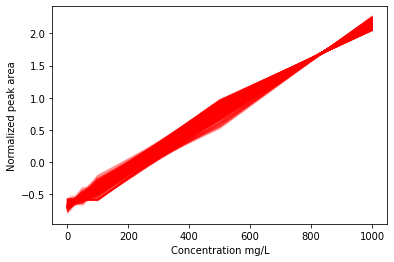

In [71]:
for i,j in d_manual.iterrows():
    plt.plot([1,5,10,50,100,500,1000], j, color='r', alpha=0.1)
plt.xlabel('Concentration mg/L')
plt.ylabel('Normalized peak area')

In [159]:
d_manual.to_excel('userdefined_priorlist_20201104.xlsx')